# Upwelling Scaling

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools
from itertools import repeat
from warnings import simplefilter
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes

%matplotlib inline
plt.rcParams['font.size'] = 12
simplefilter('ignore')

***

## Functions and definitions

Scaling diagram

In [3]:
def scaling_diagram():
    """Plot scaling diagram
    """
    
    x = np.arange(0, 1.01, 0.01)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([0, 0.1, 0.3, 1])
    ax.yaxis.set_ticks([0, 0.7, 0.9, 1])
    ax.xaxis.set_ticklabels([0, '$x_u$', '$R$', '$L$'])
    ax.yaxis.set_ticklabels(['$H$', '$z_h$', '$z_u$', 0])
    ax.plot([0.0, 1.0], [0.7, 0.7], 'k-')
    ax.plot([0.0, 0.6], [0.9, 0.7], 'm--')
    ax.plot([0.1, 0.6], [1.0, 0.7], 'm--')
    ax.plot(x, 0.2 * np.exp(-x / 0.3) + 0.7, 'k--')
    ax.plot(x, 0.3 * np.exp((0.1 - x) / 0.3) + 0.7, 'k--')
    ax.text(0.63, 0.89, '$\\frac{\\tau}{\\rho_0f}$', size=18)
    ax.text(0.05, 0.75, '$\\frac{z_u}{z_h} < 1$', size=18)
    ax.text(0.27, 0.91, '$\\frac{z_u}{z_h} > 1$', size=18)
    ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')

Plot domain

In [4]:
def plot_domain(x, y, tmask, window, gs=None, figsize=(10, 10)):
    """Plot domain in plan view (either xy or lon/lat)
    """
    
    if gs is not None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(gs[:, 0])
    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.contourf(x, y, tmask, levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(x, y, tmask, levels=[-0.01, 0.01], colors='k')
    ax.set_xlim(window[:2])
    ax.set_ylim(window[2:])
    viz_tools.set_aspect(ax)
    
    return fig, ax

Make scaling figure

In [5]:
def make_scaling_figure():
    """Make scaling figure layout
    """

    # Make figure layout
    fig, axs = plt.subplots(2, 3, figsize=(17, 10))
    xlabel = '$\\frac{\\tau T}{\\rho z_hfR}$'
    ylabels = ['$z_u/z_h$', '$x_u/R$']
    for i, row, ylabel in zip(range(2), axs, ylabels):
        for ax, hour in zip(row, hours):
            ax.set_xlim([0, 8])
            ax.set_ylim([0, 5])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if i == 0:
                ax.plot([0, 1], [0, 1], 'k--')
                ax.plot([1, 8], [1, 1], 'k--')
                ax.set_title(f'{hour} hours')
            else:
                ax.plot([1, 6], [0, 5], 'k--')
                ax.plot([1, 3.5], [0, 5], 'm--')

    return fig, axs

Make hindcast prefix

In [6]:
def make_prefix(date, paths, res='h'):
    """Make prefix
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Rossby radius

In [7]:
def calc_deformation_radius(rho, xy, z_h=None, angle=np.pi/2, tol=10):
    """Calculate the baroclinic Rossby deformation radius
    """

    # Scale factor
    scalefac = np.sin(angle) * mask.e1t[(0,)+xy[::-1]]

    # 2-layer stratification
    if z_h is not None:
        g_prime = const['g'] * (const['rho_0'] - rho) / const['rho_0']
        R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
        H, H_old = const['H'], 0
        while abs(H - H_old) > tol:
            H_old = H
            H = bathy.Bathymetry[xy[1], xy[0]:]
            H = float(H[~np.isnan(H)][:int(R / scalefac)].mean())
            R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    # Continuous stratification
    else:
        N_int = np.sqrt(const['g'] / const['rho_0'] * np.diff(rho, axis=0) * np.diff(depth2d, axis=0)).sum(axis=0)
        R_full = (N_int / (np.pi * const['f'])).compressed()
        R, R_old = np.median(R_full), 0
        while abs(R - R_old) > tol:
            R_old = R
            R = np.median(R_full[:max(1, int(R / scalefac))])

    return R

Calculate density $\rho$

In [8]:
def calc_rho(data, depth, loc, tmask, time=False):
    """Calculate the density, rho
    """
    
    if time: mskslc = slice(1, None)
    else: mskslc = slice(None)
    condition = np.broadcast_to(tmask[loc[mskslc]], data[tracers[0]][loc].shape) == 0
    rho = gsw.rho(*[np.ma.masked_where(condition, data[k][loc]) for k in tracers], depth)
    
    return rho

Definitions

In [9]:
# Definitions
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
HRDPS_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200}
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tracers = ['vosaline', 'votemper']
subdomain = [114, 398, 334, 898]
hours = [12, 24, 48]
sections = [
    {'y': 450, 'x': (235, 315), 'yw': 140, 'xw': (140, 154), 'a': np.arctan(10), 'c': 'r'},
    {'y': 500, 'x': (205, 295), 'yw': 147, 'xw': (130, 149), 'a': np.arctan( 1), 'c': 'darkorange'},
    {'y': 540, 'x': (175, 255), 'yw': 154, 'xw': (121, 140), 'a': np.arctan( 1), 'c': 'gold'},
    {'y': 590, 'x': (130, 205), 'yw': 160, 'xw': (113, 122), 'a': np.arctan( 2), 'c': 'darkslategray'},
    {'y': 640, 'x': (120, 180), 'yw': 170, 'xw': (108, 118), 'a': np.arctan(10), 'c': 'c'},
    {'y': 680, 'x': (130, 200), 'yw': 178, 'xw': (107, 116), 'a': np.arctan( 5), 'c': 'cyan'},
]

***

## Scaling method

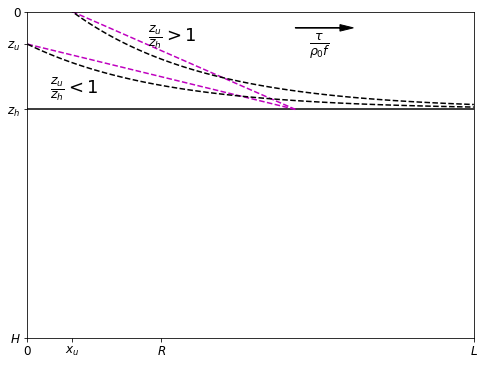

In [10]:
# Plot scaling diagram
scaling_diagram()

Conservation of mass (Ekman flux over time equals pycnocline displacement)

### Pycnocline shoaling

When $z_h/z_h < 1$

$$\underbrace{\int_{0}^\infty z_u\exp\left\{\frac{-x}{R}\right\}dx \color{magenta}{= \frac{2z_uR}{2}} = z_uR}_{\text{upwelling area}} = \underbrace{\frac{1}{\rho_0f}\int_{t_0}^{t_F}\tau dt}_{\text{cumulative Ekman transport}}$$

where

$$R = \frac{1}{f}\left(\frac{g'z_h(H - z_h)}{H}\right)^{\frac{1}{2}}$$

Thus

$$\boxed{\hspace{0.5cm}\frac{z_u}{z_h} = \frac{1}{\rho_0z_hfR}\int_{t_0}^{t_F}\tau dt\hspace{0.5cm}} \tag{1}$$

### Advection of the halocline front

When $z_u/z_h = 1$

$$\underbrace{\int_{x_u}^\infty z_h\exp\left\{\frac{x_u - x}{R}\right\}dx + z_hx_u = z_h(R + x_u)}_{\text{upwelling area}} = \underbrace{\frac{1}{\rho_0f}\int_{t_0}^{t_F}\tau dt}_{\text{cumulative Ekman transport}}$$

$\color{magenta}{\text{or}}$

$$\color{magenta}{z_h\left(R + \frac{x_u}{2}\right) = \frac{1}{\rho_0f}\int_{t_0}^{t_F}\tau dt}$$

Considering again R

$$\boxed{\hspace{0.5cm}\frac{x_u}{R} = \frac{1}{\rho_0z_hfR}\int_{t_0}^{t_F}\tau dt - 1\hspace{0.5cm}} \tag{2a}$$

$\color{magenta}{\text{or}}$

$$\color{magenta}{\boxed{\hspace{0.5cm}\frac{x_u}{R} = \frac{2}{\rho_0z_hfR}\int_{t_0}^{t_F}\tau dt - 2\hspace{0.5cm}} \tag{2b}}$$

***
## Domain sections
Plot domain sections

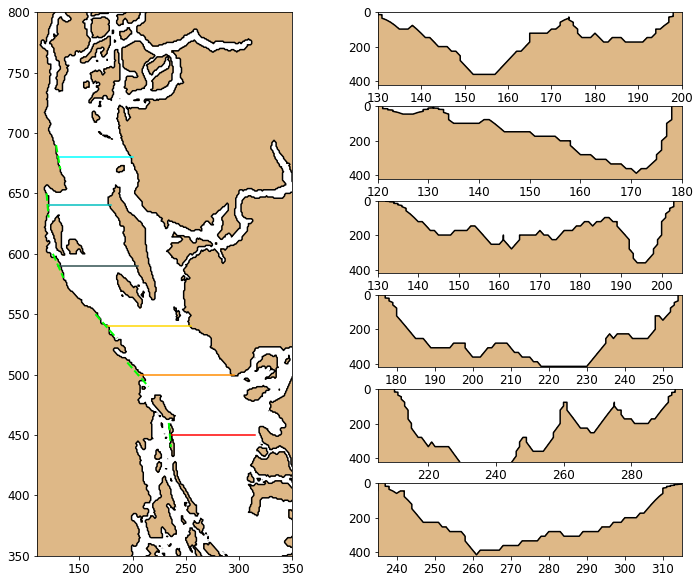

In [11]:
# Plot section locations
gs = plt.GridSpec(6, 2, hspace=0.3)
fig, ax = plot_domain(mask.x, mask.y, mask.tmask[0, 0, ...], [110, 350, 350, 800], gs=gs, figsize=(12, 10))

# Plot section bathymetry
for row, sec in zip(range(6), sections):
    line = []
    for coord, slope in zip([sec['x'][0], sec['y']], [np.tan(sec['a']), -1]):
        line.append([coord + w / slope for w in [-10, 10]])
    ax_sec = fig.add_subplot(gs[5-row, 1])
    ax.plot(sec['x'], [sec['y'], sec['y']], '-', color=sec['c'])
    ax.plot(*line, '--', linewidth=2, color='lime')
    ax_sec.contourf(mask.x, mask.gdept_1d[0, :], mask.tmask[0, :, sec['y'], :], levels=[-0.01, 0.01], colors='Burlywood')
    ax_sec.contour(mask.x, mask.gdept_1d[0, :], mask.tmask[0, :, sec['y'], :], levels=[-0.01, 0.01], colors='k')
    ax_sec.set_xlim(sec['x'])
    ax_sec.set_ylim([420, 0])

Plot wind sections

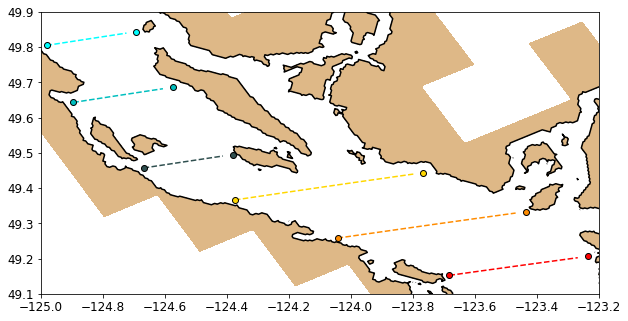

In [12]:
# Plot wind secions
tmask = np.ma.masked_where(mask.nav_lon == 0, mask.tmask[0, 0, ...])
fig, ax = plot_domain(mask.nav_lon, mask.nav_lat, tmask, [-125, -123.2, 49.1, 49.9], figsize=(10, 6))
for sec in sections:
    ax.plot(
        HRDPS_grid.longitude[sec['yw'], slice(*sec['xw'])] - 360, HRDPS_grid.latitude[sec['yw'], slice(*sec['xw'])],
        '--', color=sec['c'],
    )
    for n, x in enumerate(sec['xw']):
        lonlat = (HRDPS_grid.longitude[sec['yw'], x].values - 360, HRDPS_grid.latitude[sec['yw'], x].values)
        ax.plot(*lonlat, 'ko', markerfacecolor=sec['c'])

***
## Idealized runs
Define paths and scaling parameters

In [13]:
# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
tmask = mask.tmask[0, :, slice(*subdomain[2:]), slice(*subdomain[:2])]

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Initialize storage lists
R = [0, 0, 0, 0, 0, 0]

Idealized scaling calculations

In [14]:
def calc_scaling_ideal():
    """Calculate scaling from idealized runs
    """
    
    # Make figure layout
    fig, axs = make_scaling_figure()
    
    # Loop though z_h and rho_surf
    for z_h in tqdm(param['z_h']):
        for rho_s in param['rho_surf']:
            
            # Calculate deformation radius
            for i, sec in zip(range(6), sections):
                R[i] = calc_deformation_radius(rho_s, (sec['x'][0], sec['y']), z_h=z_h, angle=sec['a'])
                
            # Loop through wind speed
            for U, tau in zip(param['u_wind'], param['tau']):
                
                # Open results record
                runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
                with xr.open_dataset(os.path.join(path, runID, fn)) as data:
                    
                    # Loop through sections
                    for sec, r in zip(sections, R):
                        scale = np.cos(np.arctan(2) - sec['a']) * tau * 3600 / (const['rho_0'] * z_h * const['f'] * r)
                        xy = (sec['y'] - subdomain[2], slice(*[x - subdomain[0] for x in sec['x']]))
                        rho_t0 = calc_rho(data, depth2d, (0,slice(None))+xy, tmask, time=True)
                        rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - z_h).argmin(), :])
                        
                        # Loop through hours
                        for col, hour in zip(axs.T, hours):
                            scale_T = (hour - 3) * scale
                            rho = calc_rho(data, 0, (hour,0)+xy, tmask, time=True)
                            z_u = depth2d[int(np.median(abs(rho_t0 - rho.max()).argmin(axis=0))), 0] / z_h
                            x_u = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440 / r
                            col[0].plot(scale_T, z_u, 'o', color=sec['c'], markeredgecolor='k')
                            col[1].plot(scale_T, x_u, 'o', color=sec['c'], markeredgecolor='k')

### Plot idealized scaling

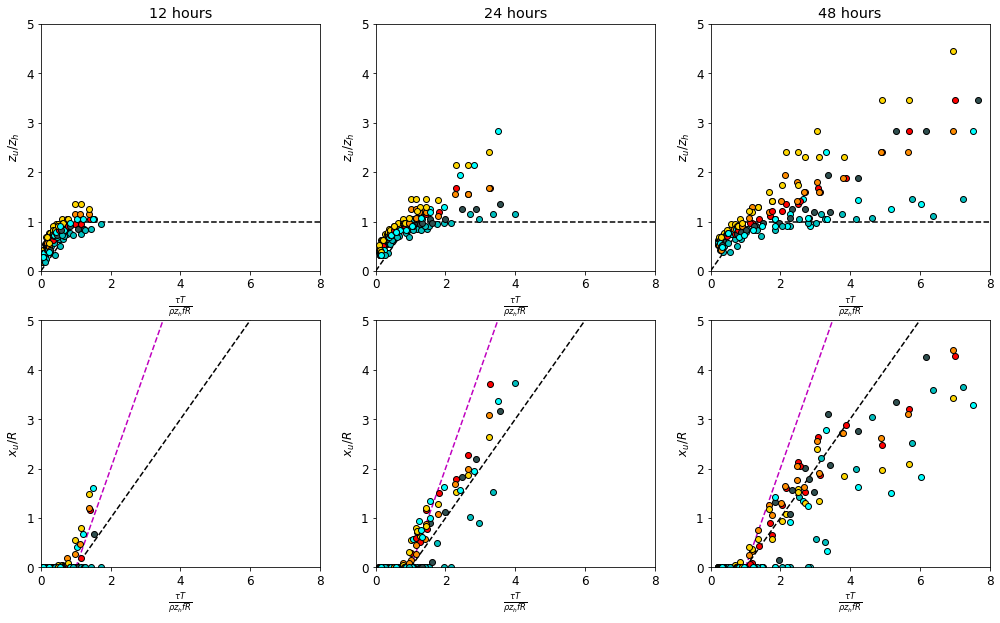

In [15]:
calc_scaling_ideal()

***

## Hindcast record

Define netCDF objects and paths

In [16]:
# Define paths and variables
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'date_cutoff': '2016 Nov 21',
}
tmask = mask.tmask
depthw = (depth2d[1:, 0] + depth2d[:-1, 0]) / 2

# Initialize storage lists
rho_t0 = [0, 0, 0, 0, 0, 0]
rho_halo = [0, 0, 0, 0, 0, 0]
R = [0, 0, 0, 0, 0, 0]
z_h = [0, 0, 0, 0, 0, 0]

Define upwelling event start dates

In [17]:
# Upwelling event date windows
events = [parse(date) for date in [
    '2015 Mar 11 04:00', #1
    '2015 Mar 18 18:00', #2
    '2015 Mar 24 22:00', #3
    '2015 Mar 28 21:00', #4
    '2015 Apr 25 23:00', #5
    '2016 Apr 11 13:00', #6
    '2017 Apr 03 23:00', #7
    '2017 May 30 15:00', #8
    '2017 Sep 08 23:00', #9
    '2017 Sep 17 02:00', #10
    '2017 Oct 21 05:00', #11
    '2018 Mar 22 07:00', #12
    '2018 Apr 03 10:00', #13
    '2018 Apr 12 23:00', #14
    '2018 Sep 07 13:00', #15
    '2018 Sep 14 18:00', #16
    '2018 Oct 23 06:00', #17
]]

Hindcast scaling calculations

In [21]:
def calc_scaling_hindcast():
    """Calculate scaling from hindcast record
    """
    
    # Make figure layout
    fig, axs = make_scaling_figure()
    
    # Loop though events and hours
    for event in tqdm(events):
        for col, hour in enumerate([0] + hours):
            
            # Open hindcast record
            date = event + timedelta(hours=hour)
            with xr.open_dataset(make_prefix(date, paths) + '_grid_T.nc') as data:
                
                # Loop through sections
                for n, sec in enumerate(sections):
                    yx = (sec['y'], slice(*sec['x']))
                    
                    # Calculations at t=0
                    if hour == 0:
                        loc = (slice(None),) + yx
                        rho_t0[n] = calc_rho(data.sel(time_counter=date, method='nearest'), depth2d, loc, tmask[0, ...])
                        N2 = const['g'] / const['rho_0'] * np.diff(rho_t0[n], axis=0) / np.diff(depth2d, axis=0)
                        modes = dynmodes(np.ma.median(N2[:, :20], axis=1).compressed()[:24], depthw[:24], 1)
                        z_h[n] = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                        rho_halo[n] = np.median(rho_t0[n][abs(depth2d[:, 0] - z_h[n]).argmin(axis=0), :])
                        rho_surf = rho_t0[n][:int(z_h[n]), :].mean()
                        R[n] = calc_deformation_radius(rho_surf, (sec['x'][0], sec['y']), z_h=z_h[n], angle=sec['a'])
                    
                    # Calculations at hours
                    else:
                        
                        # Tau
                        loc = (slice(None), sec['yw'], slice(*sec['xw']))
                        u, v = [HRDPS.sel(time=slice(event, date))[k][loc].values for k in ['u_wind', 'v_wind']]
                        U2 = np.cos(np.pi * (22 / 180 + 1) - np.arctan2(v, u) - sec['a']) * (u**2 + v**2)
                        tau = sum(1.225e-3 * U2.mean(axis=1)) * 3600
                        
                        # Scaling parameters
                        scale_T = tau / (const['rho_0'] * z_h[n] * const['f'] * R[n])
                        rho = calc_rho(data.sel(time_counter=date, method='nearest'), 0, (0,) + yx, tmask[0, ...])
                        rho_max = rho[:max(1, int(R[n] / 440))].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[n] - rho_max).argmin(axis=0))), 0] / z_h[n]
                        x_u = np.sin(sec['a']) * (rho >= rho_halo[n]).sum() * 440 / R[n]
                        
                        # Plot scaling
                        axs[0, col-1].plot(scale_T, z_u, 'o', color=sec['c'], markeredgecolor='k')
                        axs[1, col-1].plot(scale_T, x_u, 'o', color=sec['c'], markeredgecolor='k')

### Plot hindcast scaling

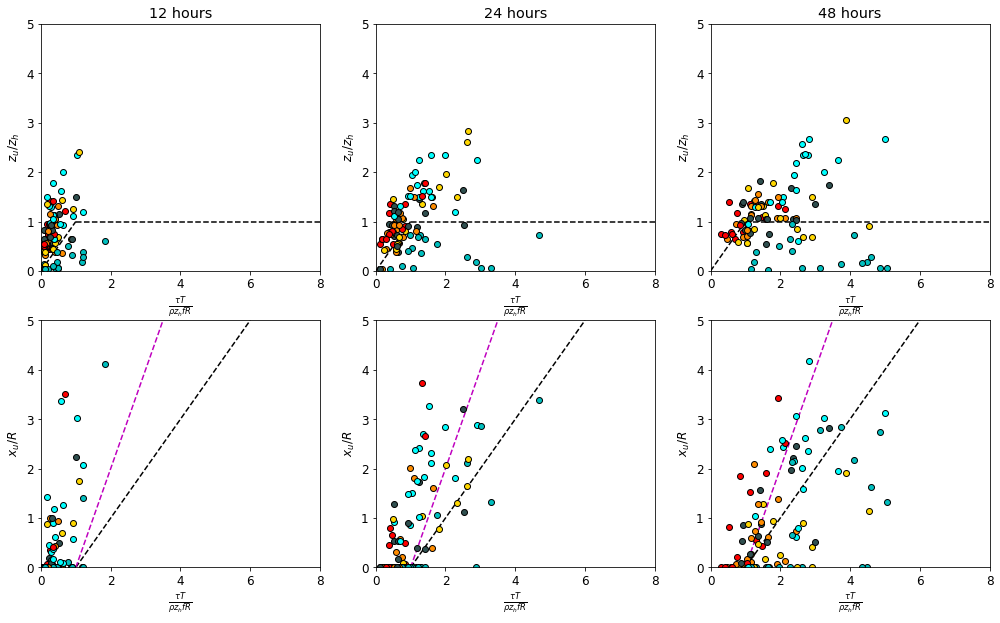

In [22]:
calc_scaling_hindcast()

***

## Vertical modes

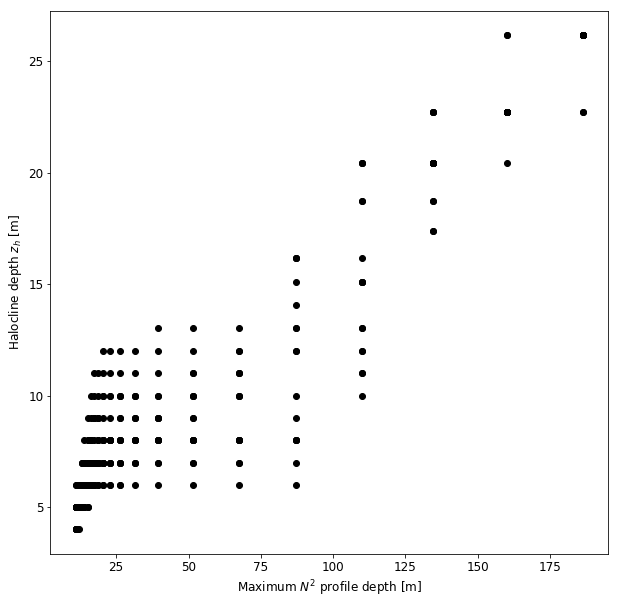

In [43]:
# Make figure layout
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Maximum $N^2$ profile depth [m]')
ax.set_ylabel('Halocline depth $z_h$ [m]')

# Loop though events and hours
for event in tqdm(events):
    
    # Open hindcast record
    with xr.open_dataset(make_prefix(event, paths) + '_grid_T.nc').sel(time_counter=event, method='nearest') as data:
        
        # Loop through sections
        for sec in [sections[2]]:
            rho = calc_rho(data, depth2d, (slice(None), sec['y'], slice(*sec['x'])), tmask[0, ...])
            N2 = const['g'] / const['rho_0'] * np.diff(rho, axis=0) / np.diff(depth2d, axis=0)
            for index in range(10, 30):
                modes = dynmodes(np.ma.median(N2[:, :20], axis=1).compressed()[:index], depthw[:index], 1)
                z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                ax.plot(depthw[index], z_h, 'ko')

***

## Wind analysis

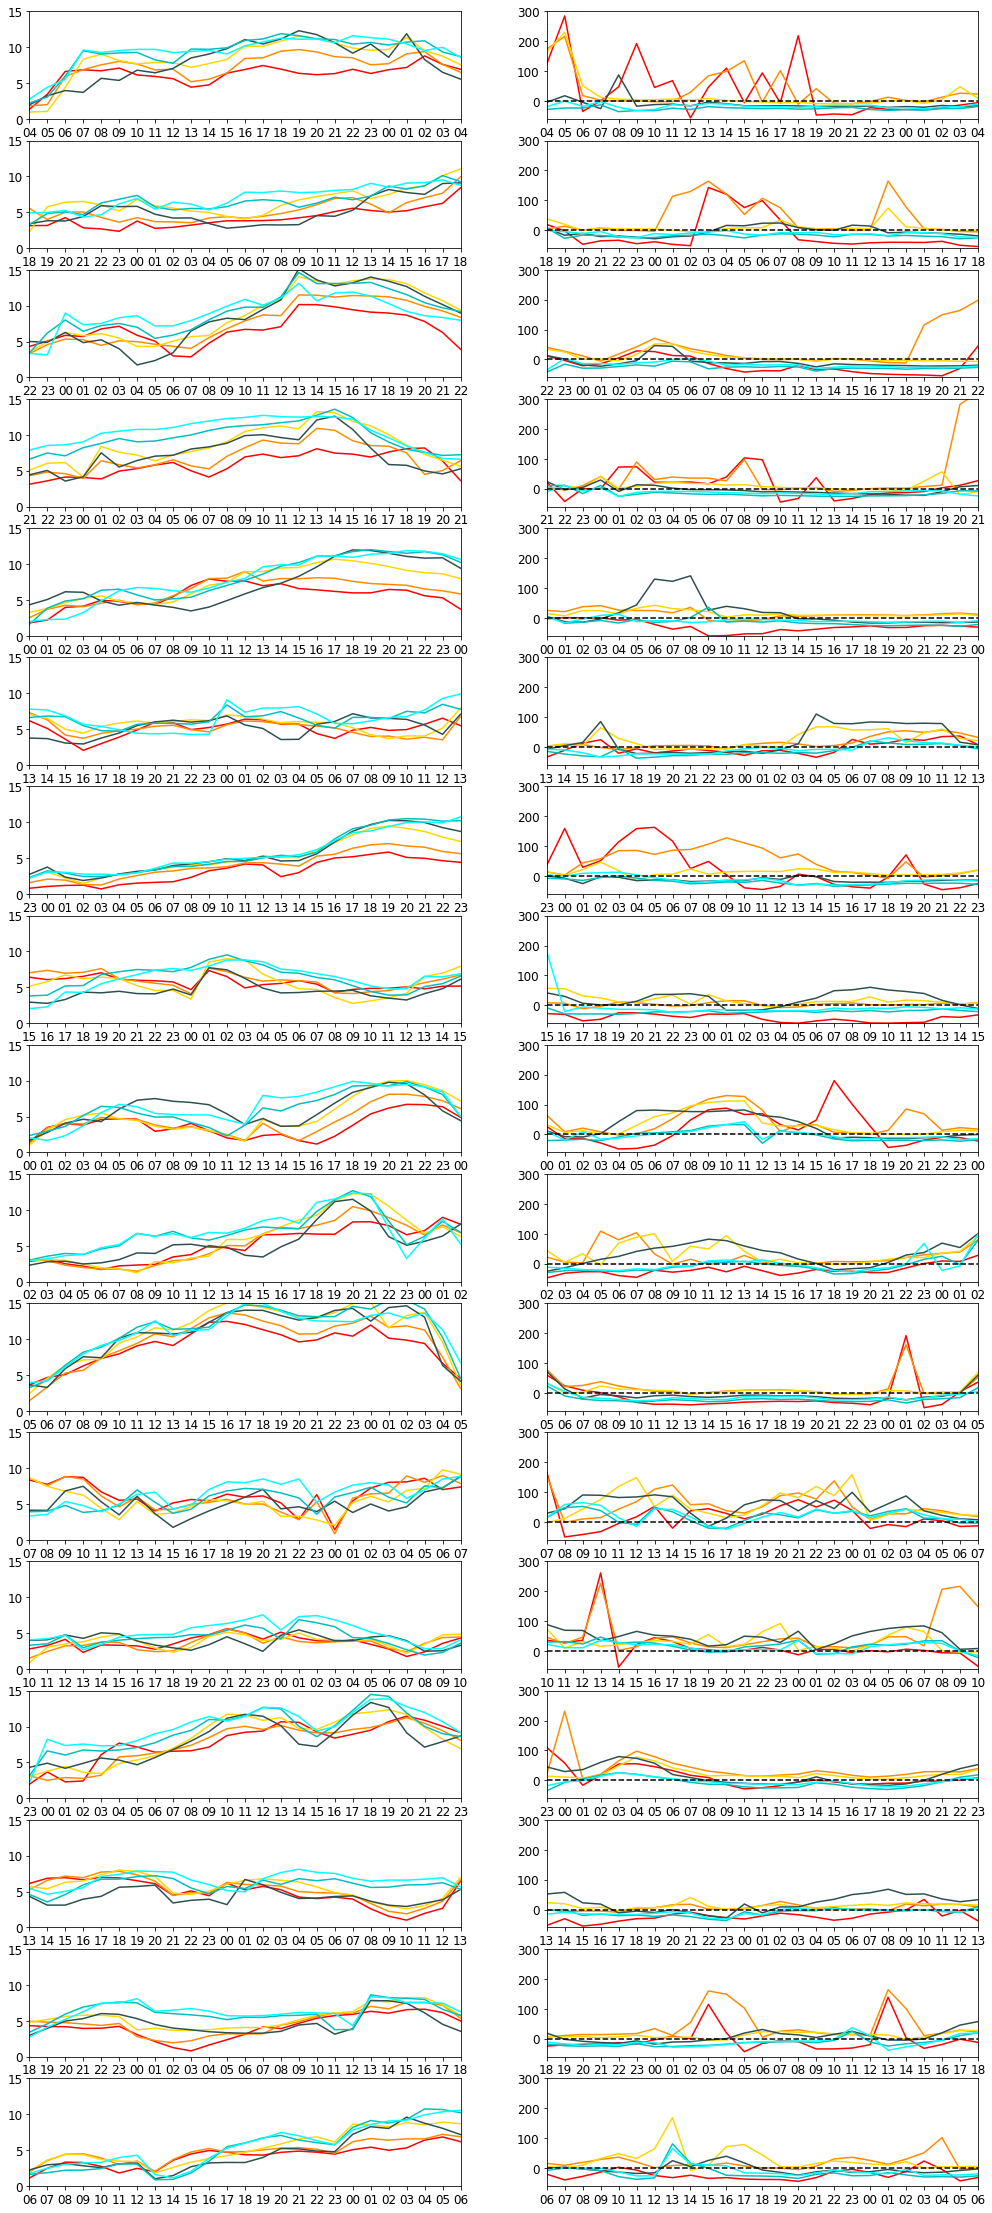

In [26]:
# Make figure layout
fig, axs = plt.subplots(17, 2, figsize=(17, 40))

# Loop though events and hours
for row, event in zip(tqdm(axs), events):
    date = (event, event + timedelta(hours=24))
    time = HRDPS.sel(time=slice(*date)).time
    for ax, ylim in zip(row, [(0, 15), (-60, 300)]):
        ax.set_xlim(date)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    for sec in sections:
        loc = (slice(None), sec['yw'], slice(*sec['xw']))
        u, v = [HRDPS.sel(time=slice(*date))[k][loc].values for k in ['u_wind', 'v_wind']]
        mag = np.sqrt(u**2 + v**2).mean(axis=1)
        angle = 180 * (1 - (np.arctan2(v, u).mean(axis=1) + sec['a']) / np.pi) + 22
        row[0].plot(time, mag, '-', color=sec['c'])
        row[1].plot(time, angle, '-', color=sec['c'])
    row[1].plot(date, [0, 0], 'k--')